First Goal is to make the computer understand the language<br>

Here are the steps

1. Sentence segmentation
2. Word tokenization
3. Stemming
4. Dependency parsing
5. Part-of-speech (POS) tagging

In [130]:
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
import spacy
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from spacy import displacy
import nltk
from nltk.parse.dependencygraph import DependencyGraph
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split

In [131]:
TAGS = False

**Prepare a proper storage**

In [132]:
class Tweet:
    def __init__(self, count, hate_speech_count, offensive_language_count, neither_count, classs, tweet):
        """
        - count (int): The total count of the tweet.
        - hate (int): The count of hate speech in the tweet.
        - offensive (int): The count of offensive language in the tweet.
        - neither (int): The count of content classified as neither hate speech nor offensive.
        - classs (str): The classification of the tweet.
        - tweet (str): The text content of the tweet.
        """
        self.count = count
        self.hate = hate_speech_count
        self.offensive = offensive_language_count
        self.neither = neither_count
        self.classs = classs
        self.tweet = tweet
        self.stems = []
        self.tokens = []
        self.code = []
        self.tags = []
        self.t_code = []
        self.presence_word = []

    def __str__(self):
        return f"{self.count} ; {self.hate} ; {self.offensive} ; {self.neither} ; {self.classs} ;; {self.tweet}"
    
    def peacefullness(self):
        return self.neither_count / self.count
    
    def offensiveness(self):
        return self.offensive / self.count
    
    def hateness(self):
        return self.hate / self.count

**Load the data**

In [133]:
Tweets = []

In [134]:
with open('./archive/train.csv', 'r+') as file:
    previous_line = ''

    # Initialize a list to accumulate the modified content
    final_content_lines = []

    # Read and accumulate non-empty lines
    for line in file:
        stripped_line = line.strip()

        if stripped_line and stripped_line[0].isdigit():
            # If the current line is not empty and starts with an integer, accumulate it
            final_content_lines.append(stripped_line)
            previous_line = stripped_line
        else:
            # If the current line doesn't start with an integer, append it to the previous line
            previous_line += stripped_line

In [135]:
for line in final_content_lines:
    
    comma_indices = [index for index, char in enumerate(line) if char == ',']

    # Extracting substrings between commas
    count_str = line[0:comma_indices[0]].strip()
    hate_str = line[comma_indices[0]+1:comma_indices[1]].strip()
    offensive_str = line[comma_indices[1]+1:comma_indices[2]].strip()
    neither_str = line[comma_indices[2]+1:comma_indices[3]].strip()
    classs_str = line[comma_indices[3]+1:comma_indices[4]].strip()
    tweet_str = line[comma_indices[4]+1:].strip()

    # Converting to integers
    count = int(count_str) if count_str.isdigit() else None
    hate = int(hate_str) if hate_str.isdigit() else None
    offensive = int(offensive_str) if offensive_str.isdigit() else None
    neither = int(neither_str) if neither_str.isdigit() else None
    classs = int(classs_str) if classs_str.isdigit() else None

    # Creating an instance of the Tweet class
    tweet_instance = Tweet(count, hate, offensive, neither, classs_str, tweet_str)

    # Append the tweet instance to a list or do whatever you need to do with it
    Tweets.append(tweet_instance)

In [136]:
for t in Tweets[:10]:
    print(t)

3 ; 0 ; 0 ; 3 ; 2 ;; !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
3 ; 0 ; 3 ; 0 ; 1 ;; !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
3 ; 0 ; 3 ; 0 ; 1 ;; !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3 ; 0 ; 2 ; 1 ; 1 ;; !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
6 ; 0 ; 6 ; 0 ; 1 ;; !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
3 ; 1 ; 2 ; 0 ; 1 ;; "!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"""
3 ; 0 ; 3 ; 0 ; 1 ;; "!!!!!!""@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit going on!"""
3 ; 0 ; 3 ; 0 ; 1 ;; !!!!&#8220

**Tweet formatting**

remove all points when it's not the end of a sentence

In [137]:
def remove_points(line):
    l = list(line)

    for i in range(len(l)):
        if i < len(l) - 2 and l[i] == '.' and 'A' <= l[i+2] <= 'Z':
            l[i] = ' '

    line = ' '.join(l)

apply first format

Let's change:
- all `@<username>` to `username`
- all URLs to `weblink`
- all `&amp` to `&`

In [138]:
for t in Tweets:
    t.tweet = re.sub(r'@([a-zA-Z0-9_]+)', 'username', t.tweet).replace('username:', '') # replace first username
    t.tweet = re.sub(r'http?://\S+', 'weblink', t.tweet)
    t.tweet = re.sub(r'&amp', '&', t.tweet)

    if t.tweet and t.tweet[0] == '.':
        t.tweet = t.tweet[1:]

In [139]:
for t in Tweets:
    remove_points(t.tweet)
    t.tweet = t.tweet   .replace('RT', '').replace('!', ' ').replace('"', '').replace("\n", ' ')\
                        .replace(';', ' ').replace('-', ' ').replace(' and ', ' & ').replace('\'', '')\
                        .replace('?', '.').replace(',', '').replace('~', ' ').replace('|', ' ').replace('°', ' ')\
                        .replace('`', ' ').replace('~', ' ').replace('*', ' ').replace('+', ' ').replace('/', ' ')\
                        .replace(' # ', ' ').replace('http', ' ').replace('t.co', ' ').replace('\\', ' ').replace('&#', ' ')
    for _ in range(4):
        t.tweet = t.tweet.replace('  ', ' ').replace('..', '.').replace(' .', '.') # remove multiple points & space
    
    if t.tweet and t.tweet[0] == ' ':
        t.tweet = t.tweet[1:]


for t in Tweets[:10]:
    print(t)


3 ; 0 ; 0 ; 3 ; 2 ;; As a woman you shouldnt complain about cleaning up your house. & as a man you should always take the trash out.
3 ; 0 ; 3 ; 0 ; 1 ;; boy dats cold.tyga dwn bad for cuffin dat hoe in the 1st place 
3 ; 0 ; 3 ; 0 ; 1 ;; username Dawg You ever fuck a bitch & she start to cry. You be confused as shit
3 ; 0 ; 2 ; 1 ; 1 ;; username she look like a tranny
6 ; 0 ; 6 ; 0 ; 1 ;; The shit you hear about me might be true or it might be faker than the bitch who told it to ya 57361 
3 ; 1 ; 2 ; 0 ; 1 ;;  The shit just blows me.claim you so faithful & down for somebody but still fucking with hoes 128514 128514 128514 
3 ; 0 ; 3 ; 0 ; 1 ;; I can not just sit up & HATE on another bitch. I got too much shit going on 
3 ; 0 ; 3 ; 0 ; 1 ;; 8220 cause Im tired of you big bitches coming for us skinny girls 8221 
3 ; 0 ; 3 ; 0 ; 1 ;; & you might not get ya bitch back & thats that 
3 ; 1 ; 2 ; 0 ; 1 ;; username :hobbies include: fighting Mariam


Change everything in **lowercase**

In [140]:
for t in Tweets:
    t.tweet = t.tweet.lower()

Change some **abbreviations**<br>
Here it is important not to change all abbreviations. some abbreviations are used by 50% of population. our model will think they are different if we don't change those 50% - 50% to a 100% unique expressions. But on the other hand, some are used by all the population (eg. `lol`) so we can keep them

In [141]:
abbr = {
    'ninstagram'        : 'instagram',
    'instagramgram'     : 'instagram',
    'ig'                : 'instagram',
    'strainstagramht'   : 'instagram',
    'insta'             : 'instagram',
    'rinstagramht'      : 'instagram',
    'ninstagramguh'     : 'instagram',
    'instagramz'        : 'instagram',
    'sinstagramn'       : 'instagram',
    'binstagramgest'    : 'instagram',
    'pinstagram'        : 'instagram',
    'linstagramht'      : 'instagram',
    'ninstagramg'       : 'instagram',
    'instagramh'        : 'instagram',
    'instagramnor'      : 'instagram',
    'ninstagramht'      : 'instagram',
    'ninstagramgramga'  : 'instagram',
    'finstagramht'      : 'instagram',
    'binstagram'        : 'instagram',
    'hinstagramh'       : 'instagram',
    'ninstagramga'      : 'instagram',
    'toninstagramht'    : 'instagram',
    'minstagramht'      : 'instagram',
    'minstagramt'       : 'instagram',
    'dwn'               : 'down',
    'dawn'              : 'down',
    'ta'                : 'that',
    'dat'               : 'that',
    'dawg'              : 'dude',
    'smh'               : 'head',
    'fr'                : 'real',
    'plz'               : 'please',
    'tf'                : 'wtf',
    'theyr'             : 'are',
    'bc'                : 'because',
    'af'                : 'lot',
    'u'                 : 'you',
    'ppl'               : 'people',
    'dm'                : 'message',
    'bf'                : 'friend',
    'gt'                : 'getting',
    'ya'                : 'yes',
    'na'                : 'no',
    'ur'                : 'your',
    'tryna'             : 'to',
    'lmfao'             : 'lmao',
    'ive'               : 'have'
}

Apply the modification 

In [142]:
for t in Tweets:
    for old in abbr:
        new = abbr[old]
        t.tweet = t.tweet.replace( ' ' + old + ' ', ' ' + new + ' ' ) # add some space arround the world to avoid matching a part of a word

Create a function that reduce the **repetitions** (people use to add a lot of letters of type a lot of emojis)<br>This reduce the data to handle

In [143]:
def reduce_repetition(s):
    # Use regular expression to find repeated substrings
    pattern = re.compile(r'(.+?)\1{%d,}' % 2)
    match = pattern.search(s)

    # Reduce repetition to two occurrences
    while match:
        repeated_substring = match.group(1)
        s = s.replace(match.group(), repeated_substring, 1)
        match = pattern.search(s)

    return s

In [144]:
for t in Tweets:
    t.tweet = reduce_repetition(t.tweet)

**Tokenisation**

In [145]:
for t in Tweets:
    t.tokens += nltk.word_tokenize(t.tweet)

In [146]:
for t in Tweets:
    for i in range(len(t.tokens) - 1, 0, -1):
        if len(t.tokens[i].strip()) == 0 or (len(t.tokens[i].strip()) == 1 and t.tokens[i].strip() != 'a' and t.tokens[i].strip() != 'i' and t.tokens[i].strip() != '&'):
            t.tokens.pop(i)

**Stemmatisation**

In [147]:
stemmer = SnowballStemmer('english')

let's **compare** original string aigains its stemmed version to see the difference and say if the **stemmatisation** is **effective**

Split according to multiple charachters

In [148]:
for t in Tweets:
    for tok in t.tokens:
        t.stems.append(stemmer.stem(tok))

In [149]:
for t in Tweets:
    for i in range(len(t.stems) - 1, 0, -1):
        if len(t.stems[i].strip()) == 0:
            t.stems.pop(i)
        elif len(t.stems[i].strip()) == 1:
            if 'a' < t.stems[i].strip() <= 'z'and t.stems[i].strip() != 'i':
                t.stems.pop(i)

In [150]:
for t in Tweets:
    for i in range(len(t.stems) - 1, 0, -1):
        arr = t.stems[i].split('.')
        t.stems[i] = arr[0]
        for j in range(1, len(arr)):
            t.stems.insert(i+j, arr[j])

Re-clean one time

In [151]:
for t in Tweets:
    for i in range(len(t.stems)):
        if t.stems[i] in abbr.keys():
            t.stems[i] = abbr[t.stems[i]]

**Dependency parsing**

Example

In [152]:
if TAGS:
    nlp = spacy.load("en_core_web_sm")

In [153]:
if TAGS:
    print(Tweets[12].tweet)
    print(Tweets[12].tokens)
    print(Tweets[12].stems, "\n")

    doc = nlp(' '.join(Tweets[12].stems))
    for token in doc:
        print(f"{token.text}: {token.dep_} -> {token.head.text}")

In [154]:
# displacy.serve(doc, style="dep")

This allow us to know the role of a word in the sentence<br>
let's store those information

In [155]:
if TAGS:
    for t in Tweets:
        doc = nlp(' '.join(t.stems))
        for token in doc:
            t.tags.append(token.dep_)

List the most used words

In [156]:
TRESHOLD = 3
code_table = []

We will record words if they are used more than `TRESHOLD`

In [157]:
used_w = {}

for t in Tweets:
    for s in t.stems:
        if not s in used_w.keys():
            used_w[s] =  1
        else:
            used_w[s] += 1

In [158]:
for k, v in sorted(used_w.items(), key=lambda item: item[1], reverse=True):
    if v < TRESHOLD:
        break
    code_table.append(k)

In [159]:
print(len(code_table))
MAX_CODE = len(code_table) + 1 # we book 1 index for the non-referenced words

5707


**Encode-Decode** functions

In [160]:
def enc(word):
    index = -1
    try:
        index = code_table.index(word)
    except ValueError:
        index = -1
    
    return index + 1

In [161]:
def dec(index):
    if index-1 >= len(code_table) or index-1 < 0: return ''
    return code_table[index-1]

A quick verification

In [162]:
print(dec(enc('hello')))

hello


In [163]:
for t in Tweets:
    for s in t.stems:
        t.code.append(enc(s))

Let's **encode** also the **tags** for the words. It will be **easier** to **handle**

In [164]:
if TAGS:
    d_tags = {}
    
    for t in Tweets:
        for g in t.tags:
            if not g in d_tags.keys():
                d_tags[g]  = 1
            else:
                d_tags[g] += 1

**Note**: Here it's not necessary to **sort** the tags usage count but it's not slowing the learning process

In [165]:
if TAGS:
    tag_code_table = []
    for k, v in sorted(d_tags.items(), key=lambda item: item[1], reverse=True):
        tag_code_table.append(k)

In [166]:
if TAGS:
    print(tag_code_table)

In [167]:
def t_enc(tag):
    index = -1
    try:
        index = tag_code_table.index(tag)
    except ValueError:
        index = -1
    
    return index + 1

In [168]:

def t_dec(index):
    ind = index - 1
    if ind >= len(tag_code_table) or ind < 0: return ''
    return tag_code_table(ind)

Record that data

In [169]:
if TAGS:
    for t in Tweets:
        for g in t.tags:
            t.t_code.append(t_enc(g))

Here's how our data looks so far!

In [170]:
if TAGS:
    table = PrettyTable(["TAG", "tag CODE", "STEM", "stem CODE"])

    for t in Tweets[:5]:
        for i in range(len(t.stems)):
            table.add_row([t.tags[i], t.t_code[i], t.stems[i], t.code[i]])
        table.add_row(['-', '-', '-', '-'])

    print(table)

Time for making a model !

Here are my ideas for the input of the model 

1. An array of this type:
  - [$stem_0$, $tag_0$, $stem_1$, $tag_1$, $stem_2$, $tag_2$ ... $stem_n$, $tag_n$]

2. Or an array of this type: 
  - [$stem_0$, $stem_1$, $stem_2$ ... $stem_n$, $tag_0$, $tag_1$, $tag_2$ ... $tag_n$]

3. Or two input arrays:
  - stem code
  - tag code

**Keras** offers us the `Embedding` layer with those arguments:

- input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.

- output_dim: Integer. Dimension of the dense embedding.

- embeddings_initializer: Initializer for the embeddings matrix (see keras.initializers).

- embeddings_regularizer: Regularizer function applied to the embeddings matrix (see keras.regularizers).

- embeddings_constraint: Constraint function applied to the embeddings matrix (see keras.constraints).

- mask_zero: Boolean, whether or not the input value 0 is a special "padding" value that should be masked out.

This is useful when using recurrent layers which may take variable length input. If this is True, then all subsequent layers in the model need to support masking or an exception will be raised. If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).

> Source: [Keras' documentation](https://keras.io/api/layers/core_layers/embedding/)

We have to figure the maximum integer index. in the 1st and 2nd case, it is equals to two times the number of words.

In [171]:
max = 0
for t in Tweets:
    if max < len(t.stems):
        max = len(t.stems)

print("max   =", max, "\n2*max =", 2*max)

max   = 67 
2*max = 134


A maximal input dimension of **500** seems enough and will allow the user to input a large text up to 500 words and **compute** it in the **model**

### Train without the word tags

The model wants 100 integers input. almost every tweet is about 50 words, let's add padding of -1

In [172]:
INPUT= 100

In [173]:
x = []
for t in Tweets:
    row = []
    for c in t.code:
        row.append(c)
    elements_to_add = INPUT - len(row)
    
    for _ in range(elements_to_add):
        row.append(0)

    x.append(row)

In [174]:
X = np.array(x)
x = None # free memory

print(X.shape)

(24783, 100)


create the hateness vector

In [175]:
y_hate = []
for t in Tweets:
    y_hate.append(t.hateness())

In [176]:
y_hate = np.array(y_hate)

In [177]:
print(y_hate[:10])

[0.         0.         0.         0.         0.         0.33333333
 0.         0.         0.         0.33333333]


In [178]:
print(y_hate.shape)

(24783,)


In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hate, test_size=.2, random_state=42)

In [180]:
print(X_train.shape)

(19826, 100)


In [181]:
# Assuming you have a vocabulary size and maximum sequence length
vocab_size = MAX_CODE  # total Number of words
max_seq_length = 100  # max number of words in a sentence

# Define the model
model = Sequential()

# Add an Embedding layer to convert words into vectors
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_seq_length))

# Add an LSTM layer to capture sequential dependencies
model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))

# Add a Dense layer for binary classification (output 1 or 0)
model.add(Dense(units=1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           285400    
                                                                 
 lstm_2 (LSTM)               (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 345901 (1.32 MB)
Trainable params: 345901 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [182]:
print(model.layers[0].input)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='embedding_2_input'), name='embedding_2_input', description="created by layer 'embedding_2_input'")


In [183]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [184]:
his = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


620/620 [==============================] - 84s 128ms/step - loss: 0.3028 - accuracy: 0.7974 - val_loss: 0.2959 - val_accuracy: 0.8003
Epoch 2/10
620/620 [==============================] - 80s 129ms/step - loss: 0.2973 - accuracy: 0.7981 - val_loss: 0.2950 - val_accuracy: 0.8003
Epoch 3/10
620/620 [==============================] - 78s 126ms/step - loss: 0.2969 - accuracy: 0.7981 - val_loss: 0.2960 - val_accuracy: 0.8003
Epoch 4/10
620/620 [==============================] - 78s 126ms/step - loss: 0.2969 - accuracy: 0.7981 - val_loss: 0.2950 - val_accuracy: 0.8003
Epoch 5/10
620/620 [==============================] - 78s 126ms/step - loss: 0.2968 - accuracy: 0.7981 - val_loss: 0.2951 - val_accuracy: 0.8003
Epoch 6/10
620/620 [==============================] - 78s 126ms/step - loss: 0.2968 - accuracy: 0.7981 - val_loss: 0.2959 - val_accuracy: 0.8003
Epoch 7/10
620/620 [==============================] - 78s 126ms/step - loss: 0.2968 - accuracy: 0.7981 - val_loss: 0.2952 - val_accuracy: 0.8

In [185]:
# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

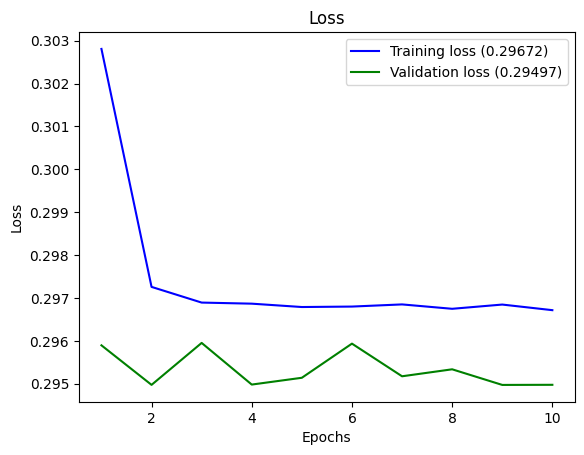

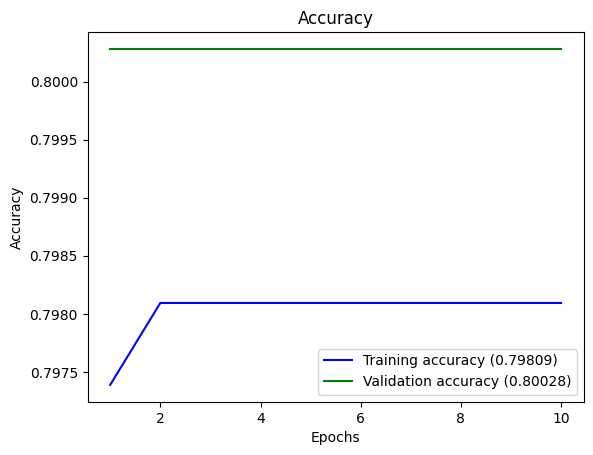

In [186]:
plot_history(his)

In [187]:
# model.save('./models/hate-v2.h5')

**Test from scratch**

In [188]:
sentence = 'roses are red, sun is yellow'

In [189]:
def preprocess(sentence):
    sent = re.sub(r'@([a-zA-Z0-9_]+)', 'username', sentence).replace('username:', '') # replace first username
    sent = re.sub(r'http?://\S+', 'weblink', sent)
    sent = re.sub(r'&amp', '&', sent)

    if sent and sent[0] == '.':
        sent = sent[1:]

    remove_points(sent)
    sent = sent   .replace('RT', '').replace('!', ' ').replace('"', '').replace("\n", ' ')\
                        .replace(';', ' ').replace('-', ' ').replace(' and ', ' & ').replace('\'', '')\
                        .replace('?', '.').replace(',', '').replace('~', ' ').replace('|', ' ').replace('°', ' ')\
                        .replace('`', ' ').replace('~', ' ').replace('*', ' ').replace('+', ' ').replace('/', ' ')\
                        .replace(' # ', ' ').replace('http', ' ').replace('t.co', ' ').replace('\\', ' ').replace('&#', ' ')
    for _ in range(4):
        sent = sent.replace('  ', ' ').replace('..', '.').replace(' .', '.') # remove multiple points & space
    
    if sent and sent[0] == ' ':
        sent = sent[1:]

    sent = sent.lower()

    for old in abbr:
        new = abbr[old]
        sent = sent.replace( ' ' + old + ' ', ' ' + new + ' ' ) # add some space arround the world to avoid matching a part of a word

    sent = reduce_repetition(sent)

    tokens = nltk.word_tokenize(sent)

    for i in range(len(tokens) - 1, 0, -1):
        if len(tokens[i].strip()) == 0 or (len(tokens[i].strip()) == 1 and tokens[i].strip() != 'a' and tokens[i].strip() != 'i' and tokens[i].strip() != '&'):
            tokens.pop(i)

    stems = []

    for tok in tokens:
        stems.append(stemmer.stem(tok))

    for i in range(len(stems) - 1, 0, -1):
        if len(stems[i].strip()) == 0:
            stems.pop(i)
        elif len(stems[i].strip()) == 1:
            if 'a' < stems[i].strip() <= 'z'and stems[i].strip() != 'i':
                stems.pop(i)


    for i in range(len(stems) - 1, 0, -1):
        arr = stems[i].split('.')
        stems[i] = arr[0]
        for j in range(1, len(arr)):
            stems.insert(i+j, arr[j])

    for i in range(len(stems)):
        if stems[i] in abbr.keys():
            stems[i] = abbr[stems[i]]

    return stems

In [190]:
print(preprocess(sentence))

['rose', 'are', 'red', 'sun', 'is', 'yellow']


In [191]:
def encode_for_model(stems):
    row  = []
    code = []
    for s in stems:
        code.append(enc(s))
    for c in code:
        row.append(c)
    elements_to_add = INPUT - len(row)
    
    for _ in range(elements_to_add):
        row.append(0)

    return np.array(row)

In [192]:
c = encode_for_model(s)

In [193]:
def prediction(sentence:str=None, code=None):
    if sentence is None and code is None:
        print("Error, function prediction waits at least a sentence or its code")
    if code is None:
        code = encode_for_model(preprocess(sentence))
    code_reshaped = np.reshape(code, (1, INPUT))
    predictions = model.predict(code_reshaped, verbose = 0)

    return predictions[0][0]

In [194]:
prediction(code=c)

0.0859596

In [195]:
m = 0
for t in Tweets[:500]:
    print(int(prediction(t.tweet)*100), int(t.hateness()*100))
    if m < prediction(t.tweet)*100:
        m = prediction(t.tweet)*100
print( m )
    

8 0
8 0
8 0
8 0
8 0
8 33
8 0
8 0
8 0
8 33
8 0
8 0
8 0
8 0
8 33
8 0
8 0
8 33
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 33
8 33
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 33
8 0
8 0
8 0
8 0
8 33
8 0
8 0
8 33
8 0
8 33
8 0
8 0
8 0
8 33
8 0
8 66
8 0
8 0
8 0
8 100
8 33
8 16
8 33
8 0
8 33
8 0
8 0
8 0
8 0
8 33
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 100
8 0
8 0
8 33
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 33
8 33
8 0
8 0
8 0
8 33
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 33
8 0
8 0
8 0
8 0
8 0
8 0
8 100
8 0
8 0
8 0
8 0
8 0
8 0
8 33
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 33
8 0
8 66
8 0
8 66
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 50
8 0
8 0
8 33
8 0
8 0
8 0
8 33
8 0
8 0
8 33
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
8 0
